In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import CanonSmiles
import numpy as np
from itertools import permutations
from collections import Counter
import random
import json
import csv
import matplotlib.pyplot as plt
import pythoncyc as pc
import requests
import os

In [2]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

## Reaction direction

Fix direction of metacyc reactions

In [20]:
metacyc_rxns_path = 'metacyc_all_reactions_smiles_221214.json'
direction_path = 'reaction_balance_direction_221214.csv'
save_to = 'metacyc_rxns_directed_221214.json'
direction_dict = {}

# Read in all metacyc reactions, not directed correctly
with open(metacyc_rxns_path, 'r') as f:
    mc_rxn_dict = json.load(f)

# Read in reaction directions
with open(direction_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0] != 'rxn_id':
            direction_dict[row[0]] = row[2]

# Check the n rxns matches the n directions
n_rxns = len(list(mc_rxn_dict.keys()))
n_directions = len(list(direction_dict.keys()))
print(n_rxns, n_directions)

# Re-direct and save
directed_rxns = {}
ct =0
for k,v in mc_rxn_dict.items():
    this_direct = direction_dict[k]
    if this_direct in ['|PHYSIOL-LEFT-TO-RIGHT|', '|IRREVERSIBLE-LEFT-TO-RIGHT|', '|LEFT-TO-RIGHT|']:
        directed_rxns[k] = [v[0], v[1]]
    elif this_direct in ['|PHYSIOL-RIGHT-TO-LEFT|', '|IRREVERSIBLE-RIGHT-TO-LEFT|', '|RIGHT-TO-LEFT|']:
        directed_rxns[k] = [v[1], v[0]]
    elif this_direct == '|REVERSIBLE|':
        ct += 1
        directed_rxns[k] = [v[0], v[1]]
        directed_rxns[k[:-1] + '_REV|'] = [v[1], v[0]]
    else:
        directed_rxns[k] = [v[0], v[1]]


# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(directed_rxns, f)

19597 19597


Save random subset of reactions

In [21]:
k = 50 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(directed_rxns.keys()), k=k)

subset_rxns = {key:directed_rxns[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

## Missing smiles

Hunt down SMILES parsing issue

In [22]:
# Bring over sanitize function from mappinng pipeline
def sanitize(list_of_smiles):
    sanitized_smiles = []
    problems = []
    missing_smiles = False
    for elt in list_of_smiles:
        if elt is None:
            missing_smiles = True

        try:
            temp_mol = Chem.MolFromSmiles(elt)
            Chem.rdmolops.RemoveStereochemistry(temp_mol)
            sanitized_smiles.append(Chem.MolToSmiles(temp_mol))
        except:
            try:
                temp_mol = Chem.MolFromSmiles(elt, sanitize=False)
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                sanitized_smiles.append(Chem.MolToSmiles(temp_mol))
            except:
                problems.append(elt)
    
    return sanitized_smiles, problems, missing_smiles

# Read in subset of mc
subset_path = '200_random_metacyc_rxns_seed_1234.json'
with open(subset_path, 'r') as f:
    subset_rxns = json.load(f)


pre_reactants_cts, pre_products_cts = [], []
post_reactants_cts, post_products_cts = [], []
not_problems = []
problems = []
rxns_missing_smiles = []
for k,rxn in subset_rxns.items():
    reactants, products = list(rxn[0].values()), list(rxn[1].values())

    # Count substrates before sanitation
    pre_reactants_cts.append(len(reactants))
    pre_products_cts.append(len(products))

    # Try to sanitize reactants, track problems
    reactants, this_problems, reactants_missing_smiles = sanitize(reactants) # Remove stereochem
    not_problems += reactants
    problems += this_problems

    # Try to sanitize products, track problems
    products, this_problems, products_missing_smiles = sanitize(products) # Remove stereochem
    problems += this_problems
    not_problems += products

    # Count sanitized substrates
    post_reactants_cts.append(len(reactants))
    post_products_cts.append(len(products))

    if (reactants_missing_smiles) or (products_missing_smiles):
        rxns_missing_smiles.append(k)

diff_reactants = [pre_reactants_cts[i] - post_reactants_cts[i] for i in range(len(pre_reactants_cts))]
diff_products = [pre_products_cts[i] - post_products_cts[i] for i in range(len(pre_products_cts))]

diff_reactants = (np.array(diff_reactants) != 0).sum()
diff_products = (np.array(diff_products) != 0).sum()



RDKit WARNING: [12:01:23] WARNING: not removing hydrogen atom without neighbors
[12:01:23] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:01:23] SMILES Parse Error: syntax error while parsing: C([R])(=O)C([O-])=O
RDKit ERROR: [12:01:23] SMILES Parse Error: Failed parsing SMILES 'C([R])(=O)C([O-])=O' for input: 'C([R])(=O)C([O-])=O'
RDKit ERROR: [12:01:23] SMILES Parse Error: syntax error while parsing: C([R])(=O)C([O-])=O
RDKit ERROR: [12:01:23] SMILES Parse Error: Failed parsing SMILES 'C([R])(=O)C([O-])=O' for input: 'C([R])(=O)C([O-])=O'
RDKit WARNING: [12:01:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:01:23] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:01:23] SMILES Parse Error: syntax error while parsing: [C@@H]([NH3+])([R])C([O-])=O
RDKit ERROR: [12:01:23] SMILES Parse Error: Failed parsing SMILES '[C@@H]([NH3+])([R])C([O-])=O' for input: '[C@@H]([NH3+])([R])C([O-])=O'
RDKit ERROR: [12:01:23] SMILE

Break out the smiles / rdkit issues by missing, parse

In [ ]:

map_path = 'temp_mapped_rxns.csv'
missing_smiles_path = 'temp_missing_smiles.csv'
parse_issue_path = 'temp_smiles_parse_issues.csv'

# Read in reaction lists
# Mapped / unmapped
mapped_rxns = []
unmapped_rxns = []
with open(map_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if len(row) > 1:
            mapped_rxns.append(row[0])
        else:
            unmapped_rxns.append(row[0])

# Missing smiles
missing_smiles_rxns = []
with open(missing_smiles_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        missing_smiles_rxns.append(row[0])

# Parse error
parse_issue_rxns = []
with open(parse_issue_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        parse_issue_rxns.append(row[0])

n_mapped = len(mapped_rxns)
n_unmapped = len(unmapped_rxns)
n_missing = len(missing_smiles_rxns)
n_parse = len(parse_issue_rxns)

print("{} out of {} reactions mapped".format(n_mapped, n_mapped + n_unmapped))
print("{} reactions missing smiles".format(n_missing))
print("{} reactions had smiles parsing issue".format(n_parse))

missing_and_parse = list(set(missing_smiles_rxns) & set(parse_issue_rxns))
mapped_and_missing = list(set(mapped_rxns) & set(missing_smiles_rxns))
mapped_and_parse = list(set(mapped_rxns) & set(parse_issue_rxns))
unmapped_and_missing = list(set(unmapped_rxns) & set(missing_smiles_rxns))
unmapped_and_parse = list(set(unmapped_rxns) & set(parse_issue_rxns))

n_mapped_missing = len(mapped_and_missing)
n_mapped_parse = len(mapped_and_parse)
n_unmapped_missing = len(unmapped_and_missing)
n_unmapped_parse = len(unmapped_and_parse)

print("\n{} out of {} mapped reactions missing smiles".format(n_mapped_missing, n_mapped))
print("{} out of {} mapped reactions w/ parse issues".format(n_mapped_parse, n_mapped))
print("\n{} out of {} unmapped reactions missing smiles".format(n_unmapped_missing, n_unmapped))
print("{} out of {} unmapped reactions w/ parse issues".format(n_unmapped_parse, n_unmapped))

31 out of 199 reactions mapped
46 reactions missing smiles
95 reactions had smiles parsing issue

1 out of 31 mapped reactions missing smiles
3 out of 31 mapped reactions w/ parse issues

45 out of 168 unmapped reactions missing smiles
92 out of 168 unmapped reactions w/ parse issues


Get ranked list of substrates with missing smiles

In [ ]:
directed_path = 'metacyc_rxns_directed_221214.json'

# Read in directed metacyc reactions
with open(directed_path, 'r') as f:
    directed_mc = json.load(f)

directed_mc[mapped_and_missing[0]]

[{'|CPD-10537|': 'C[C@@]34([C@H]2(CC[C@]5(C)([C@@H](C1(\\COC(=O)\\C=1))CC[C@](O)([C@@H]2CC[C@@H]3C[C@@H](O)CC4)5)))',
  '|Red-NADPH-Hemoprotein-Reductases|': None,
  '|OXYGEN-MOLECULE|': 'O=O'},
 {'|CPD-22576|': 'C[C@@]45([C@H](CC[C@@H]3([C@H](CC[C@]2(C)([C@@H](C1(\\COC(=O)\\C=1))[C@@H](O)C[C@@](O)23))4))C[C@@H](O)CC5)',
  '|Ox-NADPH-Hemoprotein-Reductases|': None,
  '|WATER|': 'O'}]

1936 unique compounds in metacyc missing smiles


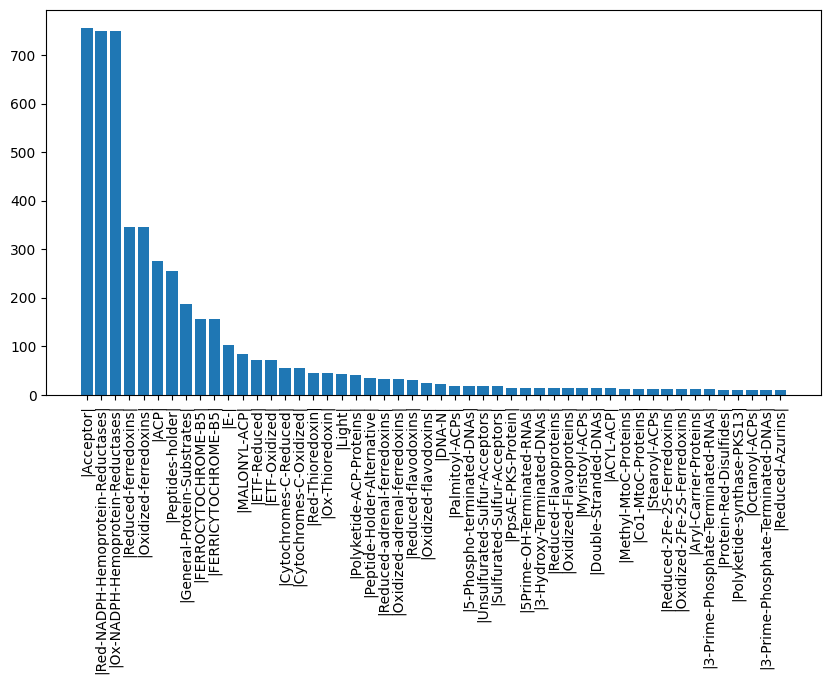

In [ ]:
subs_wo_smiles = {}
for k,v in directed_mc.items(): # Over reactions
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if (v[i][k2] is None) and (k2 not in subs_wo_smiles.keys()):
                subs_wo_smiles[k2] = 1
            elif (v[i][k2] is None):
                subs_wo_smiles[k2] += 1

subs_wo_smiles = [[elt[1], elt[0]] for elt in sorted(zip(subs_wo_smiles.values(), subs_wo_smiles.keys()), reverse=True)]
n_unique_cpds_missing_smiles = len(subs_wo_smiles)
print("{} unique compounds in metacyc missing smiles".format(n_unique_cpds_missing_smiles))

subs_wo_smiles = np.array(subs_wo_smiles)
upto = 50
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(subs_wo_smiles[:upto,0], subs_wo_smiles[:upto,1].astype(float))
ax.set_xticks(subs_wo_smiles[:upto,0])
ax.set_xticklabels(subs_wo_smiles[:upto,0], rotation=90)
plt.show()


In [ ]:
subs_wo_smiles[:upto,1].astype(float)

array([756., 749., 749., 346., 346., 275., 255., 187., 155., 155., 103.,
        84.,  71.,  71.,  54.,  54.,  45.,  45.,  43.,  40.,  35.,  32.,
        32.,  31.,  23.,  22.,  18.,  18.,  17.,  17.,  14.,  14.,  14.,
        13.,  13.,  13.,  13.,  13.,  12.,  12.,  11.,  11.,  11.,  11.,
        11.,  10.,  10.,  10.,  10.,   9.])

Throw out metacyc reactions w/o smiles and save smaller list

In [ ]:
mc_smiles_only = {}
for k,v in directed_mc.items(): # Over reactions
    is_missing = False
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if v[i][k2] is None:
                is_missing = True
                break

        if is_missing:
            break

    if not is_missing:
        mc_smiles_only[k] = v

# Save reaction dict
save_to = 'metacyc_rxns_directed_containing_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_smiles_only, f)


In [ ]:
len(list(mc_smiles_only.keys())) / len(list(directed_mc.keys()))

0.7793211339717455

Save random subset of smiles-only metacyc

In [ ]:
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_smiles_only_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(mc_smiles_only.keys()), k=k)

subset_rxns = {key:mc_smiles_only[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

## Smiles parsing issues

Load reaction test subset with no missing smiles, break out mapping, parsing issues

In [ ]:
map_path = 'smiles_only_mapped_rxns.csv'
missing_smiles_path = 'smiles_only_missing_smiles.csv'
parse_issue_path = 'smiles_only_smiles_parse_issues.csv'

# Read in reaction lists
# Mapped / unmapped
mapped_rxns = []
unmapped_rxns = []
with open(map_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if len(row) > 1:
            mapped_rxns.append(row[0])
        else:
            unmapped_rxns.append(row[0])

# Missing smiles
missing_smiles_rxns = []
with open(missing_smiles_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        missing_smiles_rxns.append(row[0])

# Parse error
parse_issue_rxns = []
with open(parse_issue_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        parse_issue_rxns.append(row[0])

n_mapped = len(mapped_rxns)
n_unmapped = len(unmapped_rxns)
n_missing = len(missing_smiles_rxns)
n_parse = len(parse_issue_rxns)

print("{} out of {} reactions mapped".format(n_mapped, n_mapped + n_unmapped))
print("{} reactions missing smiles".format(n_missing))
print("{} reactions had smiles parsing issue".format(n_parse))

missing_and_parse = list(set(missing_smiles_rxns) & set(parse_issue_rxns))
mapped_and_missing = list(set(mapped_rxns) & set(missing_smiles_rxns))
mapped_and_parse = list(set(mapped_rxns) & set(parse_issue_rxns))
unmapped_and_missing = list(set(unmapped_rxns) & set(missing_smiles_rxns))
unmapped_and_parse = list(set(unmapped_rxns) & set(parse_issue_rxns))

n_mapped_missing = len(mapped_and_missing)
n_mapped_parse = len(mapped_and_parse)
n_unmapped_missing = len(unmapped_and_missing)
n_unmapped_parse = len(unmapped_and_parse)

print("\n{} out of {} mapped reactions missing smiles".format(n_mapped_missing, n_mapped))
print("{} out of {} mapped reactions w/ parse issues".format(n_mapped_parse, n_mapped))
print("\n{} out of {} unmapped reactions missing smiles".format(n_unmapped_missing, n_unmapped))
print("{} out of {} unmapped reactions w/ parse issues".format(n_unmapped_parse, n_unmapped))

20 out of 99 reactions mapped
0 reactions missing smiles
55 reactions had smiles parsing issue

0 out of 20 mapped reactions missing smiles
1 out of 20 mapped reactions w/ parse issues

0 out of 79 unmapped reactions missing smiles
54 out of 79 unmapped reactions w/ parse issues


Inspect problematic smiles

In [ ]:
# Load in all metacyc reactions w/o missing smiles
mc_smiles_only_path = 'metacyc_rxns_directed_containing_smiles_221214.json'

with open(mc_smiles_only_path, 'r') as f:
    mc_smiles_only = json.load(f)

save_problem_compounds = 'cpds_smiles_cause_rdkit_problems.csv'

problem_cpds = []
for rxn_id in parse_issue_rxns:
    for i in range(2):
        for k,v in mc_smiles_only[rxn_id][i].items():
            temp_mol = Chem.MolFromSmiles(v)
            if temp_mol is None:
                if [k, v] not in problem_cpds:
                    problem_cpds.append([k, v])

with open(save_problem_compounds, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(problem_cpds)

RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@@H](O)COP(O[R])(=O)[O-]
RDKit ERROR: [15:05:05] SMILES Parse Error: Failed parsing SMILES 'C(O)[C@@H](O)COP(O[R])(=O)[O-]' for input: 'C(O)[C@@H](O)COP(O[R])(=O)[O-]'
RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))
RDKit ERROR: [15:05:05] SMILES Parse Error: Failed parsing SMILES 'C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))' for input: 'C([C@@H]1([C@H]([C@@H]([C@H]([C@@H](O1)O[R])O)O)O))O[C@H]2([C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O[C@H]3([C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O))'
RDKit ERROR: [15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@H]7(O[C@@H](O[R2])[C@H](O[C@@H]6(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H](O[C@H]5([C@H](O[C@@H]4(O[C

O)=1)[C@@H]5(O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]2(O[C@H]([C@H](O[R])[C@H](O)2)N3(\C=N/C4(C(/N)=N\C=N/C3=4))))[C@@H](O)[C@@H](O)5))'
[15:05:05] WARNING: not removing hydrogen atom without neighbors
[15:05:05] SMILES Parse Error: syntax error while parsing: C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)
[15:05:05] SMILES Parse Error: Failed parsing SMILES 'C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)' for input: 'C5(/C=C\C(\C(=O)N)=C/[N+](/[C@@H]1(O[C@@H]([C@H]([C@H]1O)O)COP(OP(OC[C@H]4(O[C@@H](N2(C3(\C(\N=C/2)=C(N)/N=C\N=3)))[C@H](O[R])[C@H](O)4))(=O)[O-])(=O)[O-]))=5)'
[15:05:05] SMILES Parse Error: syntax error while parsing: C(O)[C@H]1(O[C@@H]([C@H](O)[C@@H](O)[C@H](O[R1])1)O[C@H]4([C@H](O)[C@@H](O)[C@@H](O[C@H]2([C@H](O)[C@@H](O)[C@H](O[C@H](CO)2)O[C@H]3(

## 

## Fix metacyc smiles issues with other databases

### Try brenda and joseph's brenda_neutralize tsv first

Get compound names for all metacyc reactions via pythoncyc. Search brenda tsv for that entry

In [65]:
directed_path = 'metacyc_rxns_directed_221214.json'

# Read in all metacyc reactions, not directed correctly
with open(directed_path, 'r') as f:
    directed_rxns = json.load(f)

# Load in substrate entries from pc
meta = pc.so('meta')

# Get compound names for every reaction substrate
cpd_names = {}
for k,v in directed_rxns.items(): # Over reactions
    for i in range(2): # Over reactant & product dicts
        for k2 in v[i].keys(): # Over cpds in reactant / product dicts
            if k2 not in cpd_names.keys():
                cpd_names[k2] = meta[k2].names


In [66]:
n_cpds_mc = len(list(cpd_names.keys()))
brenda_path = 'brenda_neutralize.tsv'

# Load in brenda
brenda_cpd_smi = {}
with open(brenda_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        brenda_cpd_smi[row[0].lower()] = row[1]

mc_id_2_brenda_name = {}
for k,v in cpd_names.items():
    for elt in v:
        if elt.lower() in brenda_cpd_smi.keys():
            mc_id_2_brenda_name[k] = elt.lower()

len(list(mc_id_2_brenda_name.keys())) / len(list(cpd_names.keys()))

0.26490026071666767

In [67]:
# Save mc id to brenda name
save_to = 'metacyc_id_to_brenda_name.json'
with open(save_to, 'w') as f:
    json.dump(mc_id_2_brenda_name, f)

### Try modelSEED next

In [68]:
seed_path = 'modelseed_cpds_230710.json'

# Load in seed dataset
with open(seed_path, 'r') as f:
    seed_dict = json.load(f)

Search by metacyc alias first, name / synonyms after

In [70]:
# Make a dict of seed id to lowercased aliases (metacyc alias, names, synonyms, etc)
seed_id_to_aliases = {}
for k,v in seed_dict.items():
    new_aliases = []
    if 'aliases' in v.keys():
        aliases = v['aliases']
        
        for elt in aliases:
                temp = elt.split(': ')[-1].split('; ')
                new_aliases += [elt2.lower() for elt2 in temp]

    else:
        new_aliases.append(v['name'].lower())
        new_aliases.append(v['abbreviation'].lower())

    seed_id_to_aliases[k]= list(set(new_aliases))

In [85]:

# Search for metacyc cpds in the seed database
# and construct mc id to seed id dict
mc_id_2_seed_id = {}
for k,v in cpd_names.items():# Iterate over metacyc compounds
    format_k = k[1:-1].lower()
    for k2, v2 in seed_id_to_aliases.items():# Iterate over seed id -> keywords dict
        
        # Search using mc id first
        if (format_k in v2) & (k not in mc_id_2_seed_id.keys()):
            if k == '|CPD-17492|':
                print(k2, v2)
            mc_id_2_seed_id[k] = k2 # Associate mc id with seed id
        else: # Search by every name assoc w mc cpd
            for elt in v:
                if (elt.lower() in v2) & (k not in mc_id_2_seed_id.keys()):
                    if k == '|CPD-17492|':
                        print(k2, v2)
                    mc_id_2_seed_id[k] = k2


cpd02084 ['cpd-17492', 'd-2-hydroxyisocaproate', 'd-leucate', '(r)-2-hydroxy-4-methylpentanoate', '(r)-2-hydroxyisocaproate', 'c03264', '(r)-leucate']


In [86]:
# Save mc id to seed id
save_to = 'metacyc_id_to_seed_id.json'
with open(save_to, 'w') as f:
    json.dump(mc_id_2_seed_id, f)

In [87]:
len(list(mc_id_2_seed_id.keys())) / len(list(cpd_names.keys()))

0.8801309646516704

Make seed id to smiles lookup table

In [89]:
save_to = 'seed_id_to_smiles.json'

# Load jos seed cpd id to smiles list
jos_seed_path = 'SEED_neutralized.tsv'
jos_seed = {}
with open(jos_seed_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if row[0] != 'cpd':
            jos_seed[row[0]] = row[1]

# Get all the id to smiles mappings possible from current SEED
current_seed_id_2_smiles = {}
for k,v in seed_dict.items():
    if 'smiles' in v.keys():
        this_smi = v['smiles']
        this_mol = Chem.MolFromSmiles(this_smi)
        
        # Try to neutralize molecule
        if this_mol is not None: # avoid issues with MolFromSmiles
            try:
                this_neutral_mol = neutralize_atoms(this_mol) # Neutralize molecules
                this_neutral_smi = Chem.MolToSmiles(this_neutral_mol)
            except: # rdkit errors
                this_neutral_smi = this_smi
        else:
            this_neutral_smi = this_smi
        current_seed_id_2_smiles[k] = this_neutral_smi

# # Overwrite with jos where possible, his preferred
# for k,v in jos_seed.items():
#     current_seed_id_2_smiles[k] = v

print(len(list(jos_seed.keys())))
print(len(list(current_seed_id_2_smiles.keys())))

# save
with open(save_to, 'w') as f:
    json.dump(current_seed_id_2_smiles, f)

RDKit WARNING: [18:36:13] WARNING: not removing hydrogen atom without neighbors
[18:36:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:16] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:36:16]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:36:16] Conflicting single bond directions around double bond at index 1.
[18:36:16]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [18:36:16] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:36:16]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:36:16] Conflicting single bond directions around double bond at index 1.
[18:36:16]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit ERROR: [18:36:16] Explicit valence for atom # 11 B, 7, is greater than permitted
[18:36:16] Explicit valence for atom # 11 B, 7, is greater than permitte

28017
28123


Figure out how many of the missing and troublesome SMILES you have replacements for from SEED & BRENDA and update the metacyc reaction dict with these new SMILES entries

RUN CHECK_RXN_DICT_MISSING_PARSE_ISSUES_SMILES.PY HERE

In [21]:
mc2seed_path = 'metacyc_id_to_seed_id.json'
mc2brenda_path = 'metacyc_id_to_brenda_name.json'
seed2smi_path = 'seed_id_to_smiles.json'
brenda2smi_path = 'brenda_neutralize.tsv'
directed_path = 'metacyc_rxns_directed_221214.json'

# Load mc id to seed id
with open(mc2seed_path, 'r') as f:
    mc2seed = json.load(f)

# Load mc id to brenda name
with open(mc2brenda_path, 'r') as f:
    mc2brenda = json.load(f)

# Load seed id to smiles
with open(seed2smi_path, 'r') as f:
    seed2smi = json.load(f)

# Load brenda name to smiles
brenda2smi = {}
with open(brenda2smi_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if row[0] != 'cpd':
            brenda2smi[row[0]] = row[1]

# Load directed metacyc reactions
with open(directed_path, 'r') as f:
    directed_rxns = json.load(f)

# Load lists of rxns w/ cpds missing or triggering rdkit parse issues
# (were run in .py bc of rdkit issue in .ipynb)
labels = ['cpds_missing', 'rxns_missing', 'cpds_parse', 'rxns_parse']
datas = []
for i in range(len(labels)):
    load_from = f"metacyc_{labels[i]}_smiles.csv"
    with open(load_from, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        temp = []
        for row in reader:
            temp.append(row[0])
    
    datas.append(temp)

cpds_missing_smiles, rxns_w_cpds_missing_smiles, cpds_parse_issues, rxns_w_cpds_parse_issues = datas

In [24]:
# How many troublesome did you get replacements for

solved_missing = list(set(cpds_missing_smiles) & (set(mc2seed.keys()) | set(mc2brenda.keys())))
solved_parse = list(set(cpds_parse_issues) & (set(mc2seed.keys()) | set(mc2brenda.keys())))
print("Solved {} / {} missing smiles".format(len(solved_missing), len(cpds_missing_smiles)))
print("Solved {} / {} parse issues".format(len(solved_parse), len(cpds_parse_issues)))

# Replace the smiles you can in reaction dict
all_problem_rxns = list(set(rxns_w_cpds_missing_smiles) | set(rxns_w_cpds_parse_issues))
directed_rxns_updated_smiles = directed_rxns.copy()
for elt in all_problem_rxns:
    for i in range(2):
        for k,v in directed_rxns_updated_smiles[elt][i].items(): # Iterate over id:smi pairs in reac/prod
            if (k in mc2seed.keys()) and (mc2seed[k] in seed2smi.keys()):
                directed_rxns_updated_smiles[elt][i][k] = seed2smi[mc2seed[k]]
            elif (k in mc2brenda.keys()) and (mc2brenda[k] in brenda2smi.keys()):
                directed_rxns_updated_smiles[elt][i][k] = brenda2smi[mc2brenda[k]]

# Neutralize all smiles to catch the ones not update with seed and brenda         
for k,v in directed_rxns_updated_smiles.items():
    for i in range(2):
        for k2, v2 in v[i].items():
                if v2 is not None:
                    this_mol = Chem.MolFromSmiles(v2)                                 
                    
                    if this_mol is not None: # avoid issues with MolFromSmiles
                        try:
                            this_neutral_mol = neutralize_atoms(this_mol) # Neutralize molecules
                            this_neutral_smi = Chem.MolToSmiles(this_neutral_mol)
                            directed_rxns_updated_smiles[k][i][k2] = this_neutral_smi
                        except: # rdkit errors
                            pass


# Save mc reactions with smiles entries updated BUT still has some problem smiles
save_to = 'metacyc_directed_rxns_updated_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(directed_rxns_updated_smiles, f)

Solved 1675 / 1936 missing smiles
Solved 5627 / 6369 parse issues
|CPD-24446| CC(=O)N[C@@H]1([C@H]([C@@H]([C@H](O[C@@H]1OP(=O)([O-])OP(=O)(OC[C@@H]3([C@H]([C@H]([C@H](N2(\C=C/C(=O)NC2=O))O3)O)O))[O-])CO)O)NC(C[C@@H](C[R])O)=O)


RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
[19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:53:04] WARNING: not removing hy

AttributeError: 'NoneType' object has no attribute 'GetSubstructMatches'

[19:53:05] SMILES Parse Error: Failed parsing SMILES 'CC(=O)N[C@@H]1([C@H]([C@@H]([C@H](O[C@@H]1OP(=O)([O-])OP(=O)(OC[C@@H]3([C@H]([C@H]([C@H](N2(\C=C/C(=O)NC2=O))O3)O)O))[O-])CO)O)NC(C[C@@H](C[R])O)=O)' for input: 'CC(=O)N[C@@H]1([C@H]([C@@H]([C@H](O[C@@H]1OP(=O)([O-])OP(=O)(OC[C@@H]3([C@H]([C@H]([C@H](N2(\C=C/C(=O)NC2=O))O3)O)O))[O-])CO)O)NC(C[C@@H](C[R])O)=O)'


RUN CHECK_RXN_DICT_MISSING_PARSE_ISSUES_SMILES.PY HERE ON THE UPDATED METACYC REACTIONS

Check the fraction of trouble-less reactions you have with rdkit

In [93]:
# Load lists of missing and parse issues before and after update
labels = ['rxns_missing', 'rxns_parse']
path_suffixes = ['_smiles.csv', '_smiles_post_update.csv']

datas = []
for j in range(2):
    for i in range(len(labels)):
        load_from = f"metacyc_{labels[i]}" + path_suffixes[j]
        with open(load_from, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            temp = []
            for row in reader:
                temp.append(row[0])
        
        datas.append(temp)

pre_missing, pre_parse, post_missing, post_parse  = datas
pre_problems = list(set(pre_missing) | set(pre_parse))
post_problems = list(set(post_missing) | set(post_parse))
print("{} reactions with missing smiles post update comp. to {}".format(len(post_missing), len(pre_missing)))
print("{} reactions with parse issues post update comp. to {}".format(len(post_parse), len(pre_parse)))
print("{} total reactions with problems comp. to {}".format(len(post_problems), len(pre_problems)))
print("out of {} total reactions".format(len(directed_rxns.keys())))
print(len(directed_rxns.keys()) - len(post_problems), "reactions are good")

2463 reactions with missing smiles post update comp. to 4655
1335 reactions with parse issues post update comp. to 11886
3660 total reactions with problems comp. to 14348
out of 21094 total reactions
17434 reactions are good


In [94]:
# Filter out problems and save


# Load updated reaction dict (still has some troublesome smiles)
updated_rxns_path = 'metacyc_directed_rxns_updated_smiles_221214.json'
with open(updated_rxns_path, 'r') as f:
    updated_rxns = json.load(f)

mc_rxns_problems_filtered_out = {}
for k,v in updated_rxns.items():
    if k not in post_problems:
        mc_rxns_problems_filtered_out[k] = v

# Save the metacyc reactions free of problems
save_to = 'metacyc_rxns_directed_filtered_out_problem_smiles_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_rxns_problems_filtered_out, f)

# Remove protons
for id,rxn in mc_rxns_problems_filtered_out.items():
    for elt in rxn:
        if '|PROTON|' in elt.keys():
            elt.pop('|PROTON|')

# Save the metacyc reactions free of problems
save_to = 'metacyc_rxns_directed_filtered_remove_H_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_rxns_problems_filtered_out, f)

In [95]:
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_filtered_rnd_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(mc_rxns_problems_filtered_out.keys()), k=k)

subset_rxns = {key:mc_rxns_problems_filtered_out[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

## Pull modelSEED compounds and save to json

In [ ]:
n_entries = 33995 # Total number of compounds on seed as of 11/15/2022
seed_cpds_url = f"https://modelseed.org/solr/compounds/select?wt=json&fl=name,id,formula,mass,abbreviation,deltag,deltagerr,charge,aliases,smiles,ontology&q=*&rows={n_entries}&sort=id%20asc"
save_to = 'modelseed_cpds_230710.json'

# Get JSON object from model SEED
json_obj = requests.get(seed_cpds_url).json()
seed_cpds = json_obj['response']['docs'] # This comes down as a list of dicts

# Make list of dicts into dict of dicts using 
# modelSEED ids as keys
seed_dict = {}
for elt in seed_cpds:
    seed_dict[elt['id']] = elt
    
# Save seed dict
with open(save_to, 'w') as f:
    json.dump(seed_dict, f)


## Stoichiometry

In [138]:
# Pull out Geoff's reactions and format them
stoich_dir = 'geoff_rxns/'
stoich_dict = {}
sides = ['LEFT', 'RIGHT']
numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']

for fn in os.listdir(stoich_dir):
    # Read lines into a list
    with open(stoich_dir + fn, 'r') as f:
        lines = f.readlines()
        lines = [elt.rstrip('\n') for elt in lines] # Strip of new line things

        rxn_id = '|' + lines[0].split(' ')[-1] + '|'
        rxn_list = []
        non_numeric = False # Flag non-numeric stoich coeffs
        for side in sides:
            sub_dict = {}
            cpd_idxs = [] # Get indices starting w/ 'LEFT'
            for elt in lines:
                if elt[:len(side)] == side:
                    cpd_idxs.append(lines.index(elt))

            # Get stoich coeff for every cpd
            for elt in cpd_idxs:
                cpd_id = '|' + lines[elt].split(' ')[-1] + '|'
                if elt + 1 == len(lines): # If subsequent index == list length, assign 1
                    coeff = 1
                elif lines[elt + 1][:5] == '^COEF': # elif subsequent element starts with '^COEF', assign end if numeric
                    coeff = lines[elt + 1].split(' ')[-1]
                    if coeff in numbers:
                        coeff = int(coeff)
                    else:
                        non_numeric = True
                else: # else assign 1
                    coeff = 1

                sub_dict[cpd_id] = coeff # Store key:coefficient pair in dict

            rxn_list.append(sub_dict)

        # Append to stoich dict unless there were non numeric coeffs
        if not non_numeric:
            stoich_dict[rxn_id] = rxn_list

print(len(list(stoich_dict.keys()))) # Check the number of reactions w coeffs

# Apply same reaction direction preprocessing as did for reaction dict
direction_path = 'reaction_balance_direction_221214.csv'
save_to = 'stoich_metacyc_rxns_directed_221214.json'
direction_dict = {}

# Read in reaction directions
with open(direction_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0] != 'rxn_id':
            direction_dict[row[0]] = row[2]

# Re-direct and save
directed_stoich = {}
ct =0
for k,v in stoich_dict.items():
    if k in direction_dict.keys():
        this_direct = direction_dict[k]
        if this_direct in ['|PHYSIOL-LEFT-TO-RIGHT|', '|IRREVERSIBLE-LEFT-TO-RIGHT|', '|LEFT-TO-RIGHT|']:
            directed_stoich[k] = [v[0], v[1]]
        elif this_direct in ['|PHYSIOL-RIGHT-TO-LEFT|', '|IRREVERSIBLE-RIGHT-TO-LEFT|', '|RIGHT-TO-LEFT|']:
            directed_stoich[k] = [v[1], v[0]]
        elif this_direct == '|REVERSIBLE|':
            ct += 1
            directed_stoich[k] = [v[0], v[1]]
            directed_stoich[k[:-1] + '_REV|'] = [v[1], v[0]]
        else:
            directed_stoich[k] = [v[0], v[1]]

print(len(list(directed_stoich.keys()))) # Check the number of reactions w coeffs

ctr = 0
match_ctr = 0
mismatch = []
for k, v in directed_rxns.items():
    if k in directed_stoich.keys():
        ctr +=1

        rxn_cts = [sorted(list(elt.keys())) for elt in v]
        stoich_cts = [sorted(list(elt.keys())) for elt in directed_stoich[k]]
        if rxn_cts == stoich_cts:
            match_ctr += 1
        else:
            mismatch.append(k)

print("{} / {} reactions have stoich entries".format(ctr, len(list(directed_rxns.keys()))))
print("{} / {} stoich substrates match reaction substrates".format(match_ctr, ctr))

ctr = 0
for elt in mismatch:
    coeffs = []
    for i in range(2):
        coeffs += list(directed_stoich[elt][i].values())
    if max(coeffs) > 1:
        ctr +=1

print("{} / {} mismatches have non-1 stoich".format(ctr, len(mismatch)))

# Remove mismatches
for elt in mismatch:
    directed_stoich.pop(elt)

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(directed_stoich, f)

print(len(list(directed_stoich.keys()))) # Check the number of reactions w coeffs

# Make a function that will look up and apply coefficients in maprxn2rule

18099
19458
19458 / 21094 reactions have stoich entries
19164 / 19458 stoich substrates match reaction substrates
43 / 294 mismatches have non-1 stoich
19164


In [27]:
from map_rxns_to_rules_simple import count_reactants, sanitize
from itertools import combinations

def map_rxn2rule(rxn, rule):
    '''
    Maps reactions to SMARTS-encoded reaction rule.
    Args:
        - rxn: 
        - rule: smarts string
    Returns:
        - did_map (bool)
        - missing_smiles (bool)
        - smiles_parse_issue (bool)
    '''
    pre_sani_reactants, pre_sani_products = list(rxn[0].values()), list(rxn[1].values()) # Get lists of smiles

    # Initialize flags
    did_map = False
    missing_smiles = False
    smiles_parse_issue = False

    # Check for missing smiles
    if (None in pre_sani_reactants) or (None in pre_sani_products):
        missing_smiles = True
    
    reactants, products = sanitize(pre_sani_reactants), sanitize(pre_sani_products) # Remove stereochem
    
    if ((len(reactants) != len(pre_sani_reactants)) or (len(products) != len(pre_sani_products))) and (not missing_smiles) :
        smiles_parse_issue = True
    
    products = sorted(products)
    operator = Chem.rdChemReactions.ReactionFromSmarts(rule) # Make reaction object from smarts string
    reactants_mol = tuple([Chem.MolFromSmiles(elt) for elt in reactants]) # Convert reactant smiles to mol obj
    n_rule_reactants = count_reactants(rule) # No. reactants in rule

    # For every combo of reaction reactants
    for reactant_subset in combinations(reactants_mol, n_rule_reactants):
        
        # For every permutation of that subset of reactants
        for perm in permutations(reactant_subset):
            outputs = operator.RunReactants(perm) # Apply rule to that permutation of reactants
            for output in outputs:
                output = [Chem.MolToSmiles(elt) for elt in output] # Convert pred products to smiles
                output = sorted(output)

                # Compare predicted to actual products. If mapped, return
                if output == products: 
                    did_map = True
                    return did_map, missing_smiles, smiles_parse_issue
    
    return outputs

In [30]:
rxn = mc_rxns_problems_filtered_out['|RXN-10132|']
rule_id = 'rule0604'
rule = '([#8:1].[#8:2]-[#15:3]-[#8:4]).[#8:5]>>([#8:2].[#8:1]-[#15:3]-[#8:5]).[#8:4]'
outputs = map_rxn2rule(rxn, rule)
len(outputs)


1000

In [79]:
directed_rxns['|3-OH-BENZALDEHYDE-DEHYDROG-NADP+-RXN|']
directed_rxns['|RXN0-7077|']
mc_rxns_problems_filtered_out['|RXN0-7077|']

[{'|Glucopyranose|': 'C([C@@H]1([C@H]([C@@H]([C@H](C(O1)O)O)O)O))O'},
 {'|Glucopyranose|': 'C([C@@H]1([C@H]([C@@H]([C@H](C(O1)O)O)O)O))O'}]

In [140]:
foo = [1, 2, 3]
k = 4
for combo in combinations(foo, k):
    print(combo)

    for perm in permutations(combo):
        print(perm)

In [143]:
coeff = 3
v = 'foo'
single_substrate = [v for i in range(coeff)]
single_substrate

['foo', 'foo', 'foo']

In [147]:
def apply_stoich(rxn_id, rxn, stoich_dict):
    '''
    Take reaction dicts and append incremental smiles
    according to stoichiometry.
    Args:
        - rxn_id: string metacyc identifier
        - rxn: list of two dicts, with id:smi entries for substrates
    Returns:
        - reactants_smi, products_smi: two lists of substrate smiles w/ right multiplicity
    '''
    if rxn_id in stoich_dict.keys():
        output = []
        for i,elt in enumerate(rxn): # Each side of reaction
            temp = []
            for k,v in elt.items(): # Each id:smi
                coeff = stoich_dict[rxn_id][i][k]
                single_substrate = [v for i in range(coeff)]
                temp += single_substrate

            output.append(temp)

    else: # Can't find stoich
        output = [list(rxn[0].values()), list(rxn[1].values())]

    return output

rxn_id = '|COLUMBAMINE-OXIDASE-RXN|'
rxn = directed_rxns[rxn_id]
print(directed_stoich[rxn_id])
print(apply_stoich(rxn_id, rxn, stoich_dict))

[{'|OXYGEN-MOLECULE|': 1, '|COLUMBAMINE|': 2}, {'|WATER|': 2, '|BERBERINE|': 2}]
[['O=O', 'COc1cc2c(cc1O)-c1cc3ccc(OC)c(OC)c3c[n+]1CC2', 'COc1cc2c(cc1O)-c1cc3ccc(OC)c(OC)c3c[n+]1CC2'], ['O', 'O', 'COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2', 'COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2']]


## Remove transport "reactions"

In [3]:
n_entries = 33995 # Total number of compounds on seed as of 11/15/2022
transport_super_path = "https://metacyc.org/META/ajax-direct-subs?object=Transport-Reactions"
group_translocation_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-14'
diffusion_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-21'
trans_e_decarb_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-15'
trans_e_phosphoanhyd_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-13'
trans_e_membrane_echem_grad_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-12'
tonb_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-20'
trans_fac_channels_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-11'
trans_unk_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-19'

paths = [transport_super_path, group_translocation_path, diffusion_path, trans_e_decarb_path,
         trans_e_phosphoanhyd_path, trans_e_membrane_echem_grad_path, tonb_path,
         trans_fac_channels_path, trans_unk_path]

# Pull down data into json objects
jsons = []
for path in paths:
    jsons.append(requests.get(path).json())

In [4]:
# Pull ids from jsons
transport_rxn_ids = []
for elt in jsons:
    for elt2 in elt:
        if elt2['id'] not in transport_rxn_ids:
            id = '|' + elt2['id'] + '|'
            transport_rxn_ids.append([id])

# Save list of transport ids
save_to = 'transport_reactions.csv'
with open(save_to, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(transport_rxn_ids)

In [7]:
filtered_path = 'metacyc_rxns_directed_filtered_remove_H_221214.json'
transport_path = 'transport_reactions.csv'

# Load transport reactions
transport = []
with open(transport_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        transport.append(row[0])

# Load filtered metacyc
with open(filtered_path, 'r') as f:
    filtered = json.load(f)

# Remove transport reactions
ctr = 0
for elt in transport:
    if elt in filtered.keys():
        filtered.pop(elt)
        ctr += 1
    
    # Remove the reverse versions as well
    elt_rev = elt.rstrip('|') + '_REV|'
    if elt_rev in filtered.keys():
        filtered.pop(elt_rev)
        ctr += 1

print("{} / {} transports removed".format(ctr, len(transport)))

# Save reactions again after removing
save_to = 'filtered_metacyc_transport_removed_221214.json'
with open(save_to, 'w') as f:
    json.dump(filtered, f)

# Take random subsample
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_filtered_rnd_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(filtered.keys()), k=k)
subset_rxns = {key:filtered[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

1003 / 954 transports removed


## Re-neutralize seed2smiles & metacyc transport removed, rename latter as final

In [10]:
removed_transport_path = 'filtered_metacyc_transport_removed_221214.json'
seed2smi_path = 'seed_id_to_smiles.json'

with open(removed_transport_path, 'r') as f:
    removed_transport_rxns = json.load(f)

with open(seed2smi_path, 'r') as f:
    seed2smi = json.load(f)

problems = []
protons = []
for k, v in removed_transport_rxns.items():
    for i in range(2):
        for k2, v2 in v[i].items():
            if k2 == '|PROTON|':
                protons.append(v)
            try:
                temp_mol = Chem.MolFromSmiles(v2)
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                neutral_smi = Chem.MolToSmiles(neutralize_atoms(temp_mol))
                removed_transport_rxns[k][i][k2] = neutral_smi
            except:
                problems.append(k)

problems = list(set(problems))
for k in problems:
    removed_transport_rxns.pop(k)

seed_problems = []
for k, v in seed2smi.items():
    try:
        temp_mol = Chem.MolFromSmiles(v)
        Chem.rdmolops.RemoveStereochemistry(temp_mol)
        neutral_smi = Chem.MolToSmiles(neutralize_atoms(temp_mol))
        seed2smi[k] = neutral_smi
    except:
        seed_problems.append(k)

for k in seed_problems:
    seed2smi.pop(k)

# Save mc rxns
save_to = 'mc_rxns_final_221214.json'
with open(save_to, 'w') as f:
    json.dump(removed_transport_rxns, f)

# Take random subsample of mc rxns and save
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_rnd_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(removed_transport_rxns.keys()), k=k)
subset_rxns = {key:removed_transport_rxns[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)

# Save seed
save_to = seed2smi_path
with open(save_to, 'w') as f:
    json.dump(seed2smi, f)


RDKit WARNING: [16:10:37] Conflicting single bond directions around double bond at index 17.
RDKit WARNING: [16:10:37]   BondStereo set to STEREONONE and single bond directions set to NONE.
[16:10:37] Conflicting single bond directions around double bond at index 17.
[16:10:37]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:10:37] Conflicting single bond directions around double bond at index 17.
RDKit WARNING: [16:10:37]   BondStereo set to STEREONONE and single bond directions set to NONE.
[16:10:37] Conflicting single bond directions around double bond at index 17.
[16:10:37]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:10:37] Conflicting single bond directions around double bond at index 18.
[16:10:37] Conflicting single bond directions around double bond at index 18.
RDKit WARNING: [16:10:37]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:10:37] Confli

In [11]:
len(problems), len(seed_problems), len(seed2smi.keys())

(1, 28, 27986)

In [12]:
removed_transport_rxns['|RXN-22736|']

[{'|CPD-18238|': 'O=C(O)OP(=O)(O)O', '|AMMONIA|': 'N'},
 {'|CARBAMATE|': 'NC(=O)O', '|Pi|': 'O=P(O)(O)O'}]

## Break down mapping performance by EC class

In [130]:
meta = pc.so('meta')
mc_all_rxns = meta.reactions # List of pathway tools entries
rxns_w_ec = {}
rxns_wo_ec = []

for elt in mc_all_rxns:

    if elt.ec_number is not None:
        rxns_w_ec[elt.frameid] = elt.ec_number
    else:
        rxns_wo_ec.append(elt.frameid)

In [131]:
print(len(list(rxns_w_ec.keys())) / (len(list(rxns_w_ec.keys())) + len(rxns_wo_ec)))

0.7913456141246109


In [132]:
filtered_mc_path = 'mc_rxns_final_221214.json'
with open(filtered_mc_path, 'r') as f:
    filtered_mc_rxns = json.load(f)

filtered_rxns_w_ec = {}
filtered_rxns_wo_ec = []
for k,v in filtered_mc_rxns.items():
    if k.rstrip('_REV|') + '|' in rxns_wo_ec:
        filtered_rxns_wo_ec.append(k)
    elif k.rstrip('_REV|') + '|' in rxns_w_ec.keys():
        filtered_rxns_w_ec[k] = rxns_w_ec[k.rstrip('_REV|') + '|']

In [133]:
print(len(list(filtered_rxns_w_ec.keys())) / len(filtered_mc_rxns))

0.8474605954465849


In [134]:
mapping_path = 'test_rxn_mapping.csv'

# Reactions
all_rxns = []
mapped_rxns = []
rule_ct = []
unmapped_rxns = []
with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
        else:
            mapped_rxns.append(row[0])
            rule_ct.append(len(row) - 1)

In [135]:
len(mapped_rxns) / len(all_rxns)

0.81

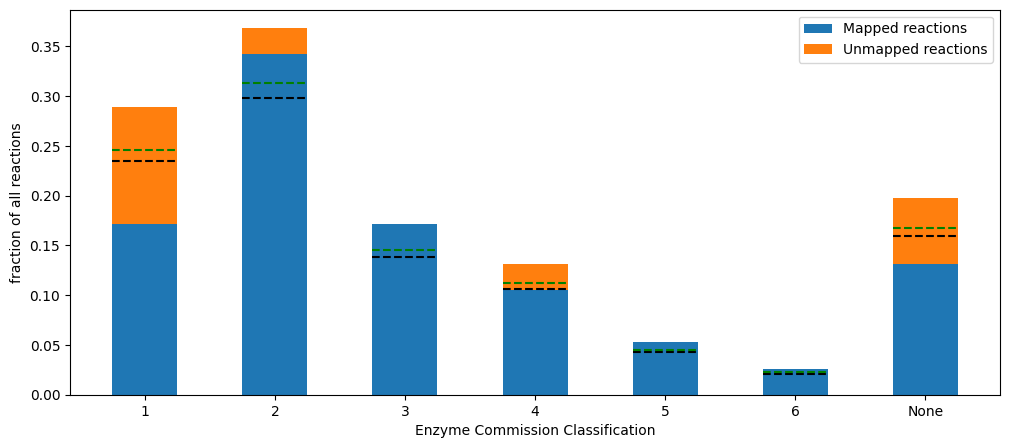

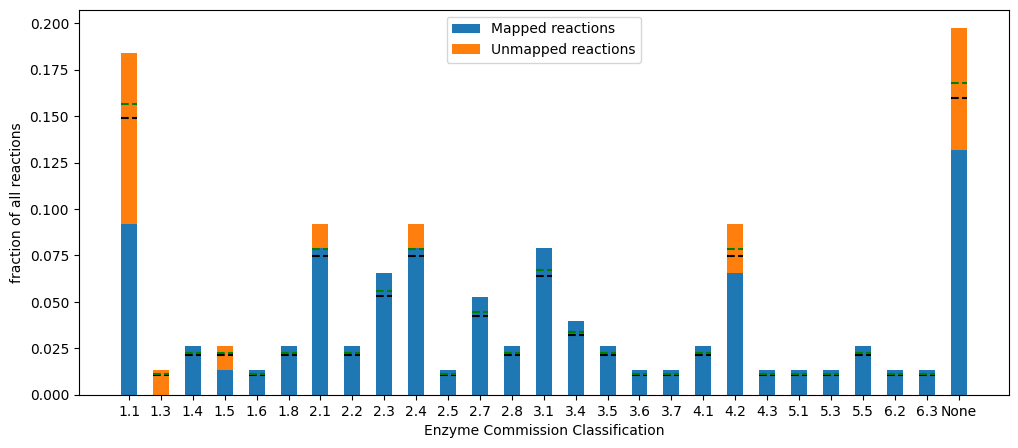

In [136]:
map_frac = len(mapped_rxns) / len(all_rxns)

# Count eccs into dicts
ec_to_rxn = [[{}, {}], [{}, {}]]
ecc_arrs = [[{}, {}], [{}, {}]]
for i, arr in enumerate([mapped_rxns, unmapped_rxns]):
    for elt in arr:
        try:
            this_ecc = meta[elt].ec_number
            if this_ecc is not None:
                this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|')
                ecc1, ecc2 = this_ecc[0], this_ecc[:3]

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                    ec_to_rxn[i][0][ecc1] = [elt]
                else:
                    ecc_arrs[i][0][ecc1] += 1
                    ec_to_rxn[i][0][ecc1].append(elt)

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                    ec_to_rxn[i][1][ecc2] = [elt]
                else:
                    ecc_arrs[i][1][ecc2] += 1
                    ec_to_rxn[i][1][ecc2].append(elt)
            else:
                if 'None' not in ecc_arrs[i][0]:
                    ecc_arrs[i][0]['None'] = 1
                    ec_to_rxn[i][0]['None'] = [elt]
                else:
                    ecc_arrs[i][0]['None'] += 1
                    ec_to_rxn[i][0]['None'].append(elt)

                if 'None' not in ecc_arrs[i][1]:
                    ecc_arrs[i][1]['None'] = 1
                    ec_to_rxn[i][1]['None'] = [elt]
                else:
                    ecc_arrs[i][1]['None'] += 1
                    ec_to_rxn[i][1]['None'].append(elt)

        except:
            pass

ec_1st_union = list(set(ecc_arrs[0][0].keys()) | set(ecc_arrs[1][0].keys()))
ec_2nd_union = list(set(ecc_arrs[0][1].keys()) | set(ecc_arrs[1][1].keys()))
for elt in ecc_arrs:
    for k in ec_1st_union:
        if k not in elt[0].keys():
            elt[0][k] = 0

    for k in ec_2nd_union:
        if k not in elt[1].keys():
            elt[1][k] = 0


# Make two plots
labels = ['Mapped reactions', 'Unmapped reactions']
width = 0.5
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    tot = sum(list(ecc_arrs[0][i].values()))
    

    for j in range(2): # Iterate over mapped, unmapped
        xs = np.arange(len(ecc_arrs[j][i]))
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 0:
            
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_names = names
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * map_frac, x - width / 2, x + width / 2, color='k', ls='--')
        ax.hlines(top * 0.85, x - width / 2, x + width / 2, color='g', ls='--')
    
    ax.set_xlabel(f"Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()

In [137]:
unmapped_rxns

['|RXN-4733|',
 '|RXN-14681|',
 '|RXN-9486|',
 '|RXN-3625|',
 '|RXN-15262|',
 '|RXN-7981|',
 '|RXN-8885|',
 '|RXN-12605|',
 '|RXN-8128|',
 '|RXN-17714|',
 '|RXN-14678|',
 '|RXN-17648|',
 '|RXN-19290|',
 '|RXN-12976|',
 '|RXN-16449|',
 '|RXN-16803|',
 '|RXN-17342|',
 '|RXN-19534_REV|',
 '|RXN1A0-6318|']

In [65]:
filtered_mc_rxns['|RXN0-5204|']

[{'|PepB-Aminopeptidase-Substrates|': '*C(=O)C(*)NC(=O)C(*)N', '|WATER|': 'O'},
 {'|Amino-Acids-20|': '*C(N)C(=O)O',
  '|Peptide-Holder-Alternative|': 'CNC(=O)C(C)NC(=O)C(C)NC(=O)C(C)N'}]

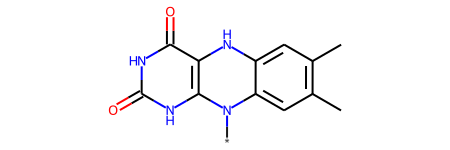

In [60]:
m = Chem.MolFromSmiles('*N1c2cc(C)c(C)cc2Nc2c1[nH]c(=O)[nH]c2=O')
m

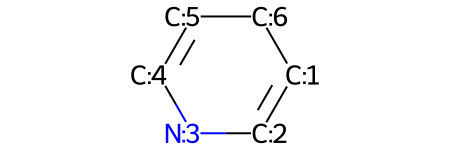

In [62]:
patt = Chem.MolFromSmarts('[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1')
patt

In [63]:
m.HasSubstructMatch(patt)

False

In [18]:
def sanitize(list_of_smiles):
    sanitized_smiles = []
    for elt in list_of_smiles:
        temp_mol = Chem.MolFromSmiles(elt)
        Chem.rdmolops.RemoveStereochemistry(temp_mol)
        sanitized_smiles.append(Chem.MolToSmiles(temp_mol))    
    return sanitized_smiles
sanitize(['C(=O)([O-])N'])

['NC(=O)[O-]']

## Cofactors

In [22]:
# Read in paired cofactor lookup table
cofactor_pair_path = 'cofactor_pair_alldb.json'
with open(cofactor_pair_path, 'r') as f:
    cofactor_pairs = json.load(f)

# Read in list of unpaired cofactors
unpaired_path = 'cofactor_list_alldb.tsv'
unpaired_cofactors = []
with open(unpaired_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        unpaired_cofactors.append([row[0], row[1]])

unpaired_cofactors = unpaired_cofactors[1:] # Take out header
rhs_unpaired_cofactors = [elt[1] for elt in unpaired_cofactors] # Jos uses rhs column in rules csv
rhs_unpaired_cofactors = list(set(rhs_unpaired_cofactors))

# Read in rules
rules_path = 'minimal1224_all_uniprot.tsv'
rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        rules.append([row[0], row[1], row[3]])

rules = rules[1:] # Remove header
rule_cofactors = []
for elt in rules:
    rule_cofactors += elt[1].split(';')
    rule_cofactors += elt[2].split(';')

rule_cofactors = list(set(rule_cofactors))

lu_cofactors = []
for k in cofactor_pairs.keys():
    lu_cofactors += k.split(',')

lu_cofactors = list(set(lu_cofactors))
cofactors = lu_cofactors + rhs_unpaired_cofactors

# Remove the cofactors not in the rules
temp = []
for elt in cofactors:
    if elt in rule_cofactors:
        temp.append(elt)

cofactors = temp

(40, 41)

In [ ]:
# Make a list of MC ids for all paired and unpaired cofactors

# Filter out metacyc reactions which only have these as substrates

# Construct a cofactor pairs lookup table w Jos labels mapped to 
# cpds, w everything expressed in MC ids

# Construct a lookup table of Jos rule cofactor names
# mapped to their SMARTS patterns within the rule

# Write function to replace paired cofactors from metacyc
# w the SMILES version of the SMARTS patterns of the 
# Jos rule cofactors they correspond to

## Check atom balance

In [ ]:
def count_atoms(smi_str):
    '''
    Count atoms in provided smile string and
    return dict of element:count pairs.
    '''
    
    # Single letter elt dict w lowercase rpts for aromatics
    one_letter_elts = {'B':0, 'C':0, 'N':0, 'O':0,
                        'F':0, 'P':0, 'S':0, 'I':0,
                        'W':0, 'c':0, 'n':0, 'o':0,
                        's':0}
    
    aromatic_elts = ['c', 'n', 'o', 's'] # Keep track of aromatic elts
    
    # Two letter elements
    two_letter_elts = {'Li':0, 'Be':0, 'Ne':0, 'Na':0, 'Mg':0,
                        'Al':0, 'Cl':0, 'Ca':0, 'Fe':0,'Ni':0,
                        'Zn':0, 'Br':0, 'Te':0, 'As':0, 'Sb':0,
                        'Cu':0}

    # Count single letter elements...
    # use Counter for single letter elts
    single_elt_cts = Counter(one_letter_elts)
    single_elt_cts.update(smi_str)
    temp = {} # To replace one_letter_elts
    for k in one_letter_elts.keys():
        temp[k] = single_elt_cts[k]

    # Combine aromatic counts
    for elt in aromatic_elts:
        temp[elt.upper()] = temp[elt.upper()] + temp[elt]
        temp.pop(elt) # Remove lowercase keys after done w em

    # Count two letter elements...
    # use .count() for two letter elts
    for k in two_letter_elts.keys():
        two_letter_elts[k] = smi_str.count(k)

    cts = {**temp, **two_letter_elts} # Combine one, two letter cts
    return cts

In [128]:
# Load final metacyc rxns
mc_rxns_path = 'mc_rxns_final_221214.json'
with open(mc_rxns_path, 'r') as f:
    mc_rxns = json.load(f)

# Load in stoich
stoich_path = 'mc_rxns_final_221214.json'
with open(stoich_path, 'r') as f:
    stoich = json.load(f)

# Make SMILES soup set
# and check out all unique characters
smi_soup = ''
for k,v in mc_rxns.items():
    for elt in v:
        for k2, v2 in elt.items():
            smi_soup += v2

smi_soup_unique = list(set(smi_soup))
print(len(smi_soup_unique))
print(smi_soup_unique)


# Check atom balance w/o Geoffs stoich
unbalanced = []
for k,v in mc_rxns.items():
    reactant_sum = {}
    for smi in v[0].values():
        cpd_ct = count_atoms(smi)
        for k2, v2 in cpd_ct.items():
            if k2 not in reactant_sum:
                reactant_sum[k2] = v2
            else:
                reactant_sum[k2] += cpd_ct[k2]

    product_sum = {}
    for smi in v[1].values():
        cpd_ct = count_atoms(smi)
        for k2, v2 in cpd_ct.items():
            if k2 not in product_sum:
                product_sum[k2] = v2
            else:
                product_sum[k2] += cpd_ct[k2]

    for k2 in reactant_sum.keys():
        if reactant_sum[k2] - product_sum[k2] != 0:
            unbalanced.append(k)
            break

print("No stoich:", len(unbalanced), len(mc_rxns.keys()))

# Remove unbalanced 
for elt in unbalanced:
    mc_rxns.pop(elt)

# Save mc rxns
save_to = 'mc_rxns_final_221214.json'
with open(save_to, 'w') as f:
    json.dump(mc_rxns, f)


# # Check atom balance w/ Geoffs stoich
# unbalanced = []
# for k,v in mc_rxns.items():
#     reactant_sum = {}
#     for id, smi in v[0].items():
#         cpd_ct = count_atoms(smi)

#         # Get stoich
#         if id in stoich.keys():
#             coeff = stoich[id]
#         else:
#             coeff = 1

#         for k2, v2 in cpd_ct.items():
#             if k2 not in reactant_sum:
#                 reactant_sum[k2] = v2 * coeff
#             else:
#                 reactant_sum[k2] += v2 * coeff

#     product_sum = {}
#     for id, smi in v[1].items():
#         cpd_ct = count_atoms(smi)

#         # Get stoich
#         if id in stoich.keys():
#             coeff = stoich[id]
#         else:
#             coeff = 1

#         for k2, v2 in cpd_ct.items():
#             if k2 not in product_sum:
#                 product_sum[k2] = v2 * coeff
#             else:
#                 product_sum[k2] += v2 * coeff

#     for k2 in reactant_sum.keys():
#         if reactant_sum[k2] - product_sum[k2] != 0:
#             unbalanced.append(k)
#             break

# print("W/ stoich:", len(unbalanced), len(mc_rxns.keys()))


47
['O', '*', '#', 'T', 'I', '2', 'e', 'l', '(', '~', 'N', 'g', 'C', 'P', '5', '.', '%', 'A', 'a', ']', 's', '=', 'H', '3', 'u', 'S', '9', '-', '1', 'i', 'B', '7', '8', 'r', '[', '6', ')', '+', '4', 'F', 'M', 'n', 'W', 'b', '0', 'o', 'c']
No stoich: 0 11420


## Sample latest Metacyc reaction dict

In [129]:
# Load final metacyc rxns
mc_rxns_path = 'mc_rxns_final_221214.json'
with open(mc_rxns_path, 'r') as f:
    mc_rxns = json.load(f)

# Take random subsample of mc rxns and save
k = 100 # How many rxns to choose
seed = 1234 # Random seed
save_to = f"{k}_random_metacyc_rxns_rnd_seed_{seed}.json"

random.seed(seed)
rxn_ids = random.choices(list(mc_rxns.keys()), k=k)
subset_rxns = {key:mc_rxns[key] for key in rxn_ids}

# Save reaction dict
with open(save_to, 'w') as f:
    json.dump(subset_rxns, f)